# Setup

Ideally we remove the modules we do not use...

In [1]:
from collections import Counter
from datetime import datetime
from dateutil import tz
from IPython.display import HTML

import inspect
import json
import gc
import re
import os
import sys
import pprint
import antigravity
import math

#model
from scipy import stats
from scipy.stats import mstats

from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.feature_selection._base import SelectorMixin
from sklearn.feature_extraction.text import _VectorizerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold,RandomizedSearchCV,GridSearchCV
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Integer
from skopt.callbacks import DeadlineStopper
from skopt.callbacks import VerboseCallback
from skopt.callbacks import DeltaXStopper

from spacy import displacy
from spacy.matcher import Matcher,PhraseMatcher

import numpy as np
import pandas as pd
import spacy
import xgboost as xgb
import lightgbm as lgb

from ray import tune

#plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#nlp
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from spacy.tokens import Token
from sklearn.cluster import KMeans

%load_ext line_profiler

## Environment

In [2]:
# Not executing this causes tuning to fail later
!pip uninstall dataclasses -y

Found existing installation: dataclasses 0.6
Uninstalling dataclasses-0.6:
  Successfully uninstalled dataclasses-0.6


In [3]:
#global variables
RANDOM_STATE=42

In [4]:
#🐼
pd.set_option("max_colwidth", 150)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 500)

# Data

In [5]:
#utility: read all data with format defined
def load_data(path):
    df=pd.read_csv(filepath_or_buffer=path,
                   index_col='ClaimNumber',
                   parse_dates=['DateTimeOfAccident','DateReported'],
                   dtype={'Age':'int8','DependentChildren':'int8','DependentsOther':'int8','DaysWorkedPerWeek':'int8',
                          'Gender':'category','MaritalStatus':'category','PartTimeFullTime':'category'}
                  )
    
    df.rename(columns={'InitialIncurredCalimsCost':'InitialIncurredClaimCost'},inplace=True)
    
    return df

In [6]:
data = load_data(path='../input/actuarial-loss-estimation/train.csv')

In [7]:
def preprocess(data):
    
    '''Preprocess the data outside of the pipeline. New columns are mainly created here.'''
    
    if isinstance(data, pd.DataFrame):
        
        #setup
        df_=data.copy()
        target_variable = 'UltimateIncurredClaimCost'
        
        #kill absurd values
        df_['MaritalStatus'].fillna(value = "U", inplace = True)
        df_['WeeklyWages'] = np.where(df_['WeeklyWages']<=1,np.nan,df_['WeeklyWages'])
        df_['HoursWorkedPerWeek'] = np.where((df_['HoursWorkedPerWeek']>=168) | (df_['HoursWorkedPerWeek']==0),np.nan,df_['HoursWorkedPerWeek']) 
        df_['DateReported'] = np.where(df_.DateReported < df_.DateTimeOfAccident, df_.DateTimeOfAccident, df_.DateReported)
        
        #new columns
        df_['YearOfAccident']=df_.DateTimeOfAccident.dt.year
        df_['WeekDayOfAccident']=df_.DateTimeOfAccident.dt.weekday
        df_['HourOfAccident']=df_.DateTimeOfAccident.dt.hour
        df_['YearReported']=df_.DateReported.dt.year
        df_['YearBirth'] = df_['YearOfAccident'] - df_['Age']
        df_['ReportingDelay']= df_.DateReported - df_.DateTimeOfAccident
        df_['ReportingDelayInDays']=df_.ReportingDelay.dt.days
        df_['DescriptionLength'] = df_.ClaimDescription.apply(lambda x : len(set(x.split())))
        df_["NewBusiness"] = np.where(df_.YearReported >= 2000,1,0)
        df_["OldBusiness"] = np.where(df_.YearReported <= 1995,1,0)
        
        conditions=[(df_.HourOfAccident <= 5),(df_.HourOfAccident > 5) & (df_.HourOfAccident < 17),(df_.HourOfAccident >= 17)]
        values=[0,1,0]
        df_['CoreWorkingHour']=np.select(conditions,values)
        
        #impute missing valuesì
        imputer = SimpleImputer(strategy="most_frequent")
        predictors = ['Gender']
        df_[predictors] = imputer.fit_transform(df_[predictors])
        
        #one hot encoding
        onehot_encoded_features=['Gender','PartTimeFullTime', 'MaritalStatus']
        df_onehot=pd.get_dummies(data=df_[onehot_encoded_features],prefix=['ohe_' + feature for feature in onehot_encoded_features])
        df_=pd.concat(objs=[df_,df_onehot],axis=1)
            
        #common claims modelling
        common_claims = ["SLIPPED USING LATHE IN EYE CORNEA", "REDBACK SPIDER BITE RIGHT FOOT RIGHT FRACTURE", "LIFTING TYRES LOWER BACK STRAIN",
                         "LIFTING BACK STRAIN LOWER BACK STRAIN", "FELL DOWN STAIRS BACK SPRAIN",
                         "USING AIR HOSE STRAIN RIGHT KNEE RIGHT", "FRACTURED LEFT WRIST FRACTURE LEFT MIDDLE FINGER" ]
        for description in common_claims:
            df_[description] = np.where(df_.ClaimDescription == description,1,0)
                
        #adjustments that are either train or test data specific
        if 'ohe_Gender_U' in df_.columns: df_.drop(columns='ohe_Gender_U',inplace=True)
        if 'WC9016054' in df_.index: df_.drop(index='WC9016054',inplace=True) #the Casanova: the guy is 22, single, but has 9 (!) children. Ultimate vs initial: 457k vs 28k
        if 'WC9916019' in df_.index: df_.drop(index='WC9916019',inplace=True) #absurdly high ultimate value
        if 'WC9269123' in df_.index: df_.drop(index='WC9269123',inplace=True) #absurdly high initial value
        
        return df_
    
    else:
        raise TypeError("input must be of type pandas.DataFrame")

# NLP

In [8]:
#language model
nlp = spacy.load(name = 'en_core_web_lg')

#stopwords
stop = set(stopwords.words('english'))
stop.update(["left", "right"])

#stemmer
stemmer = SnowballStemmer(language='english')
def get_stemmed_form(token):
    return stemmer.stem(token.lemma_)

Token.set_extension('stem', getter = get_stemmed_form, force = True)

In [9]:
body_parts = ['ankl','arm', 'artery', 'back', 'belly', 'big toe', 'blood', 'bone', 'breast', 'buttocks',
              'calf', 'cartilage', 'cheek', 'chest', 'chin', 'clavicle', 'coccyx', 'collar bone', 
              'ear', 'elbow', 'eye','face', 'feet', 'fibula', 'finger', 'foot', 'forehead', 'groin', 'gums', 'hair', 'hand', 'head', 'heel', 'hip',
              'jaw', 'knee', 'leg', 'ligament', 'lip', 'liver', 'lobe', 'lungs',
              'metacarpal', 'metatarsal', 'mouth', 'muscl', 'nail', 'neck', 'nerves', 'nipple', 'nose','palm', 'patella', 'pelvis',
              'radius', 'ribs', 'scalp', 'scapula', 'shin', 'shoulder', 'skin', 'skull', 'sole', 
              'spine', 'sternum', 'stomach', 'teeth', 'tendon', 'thigh', 'throat', 'thorac', 'thumb', 'tibia', 'tissu', 'toe', 'tongue', 'tooth', 'torso', 'ulna', 'vein', 'vertebra', 'wrist',
              'forearm', 'cornea', 'corneal', 'inguin', 'muscular', "abdomin", "eyelid", "forefing", "fingernail", "meniscus", "facial", "dental", "thumbs", "epicondyl","carpel tunnel","fibre"]

wound_types = ["strain", "lacer", "bruis", "cut", "sprain", "fractur", "grind", "burn", "punctur", "crush", "infect", "dislocate","whiplash", "twist", "abras", 
               "break", "tear", "hernia", "sore", "broken", "concuss", "torn", "amput", "allerg", "depress", "inflamm", "headach", "ulcer", "stung", "mental", "nausea", "disord",
              "victimis", "allergi", "arthriti", "broke", "multipl"]
accident_causes = ["lift", "pull", "drop", "hit", "fall", "foreign", "knife", "metal", "vehicl", "door", "hammer", "bite", "chemic", "strike", "slip", 
                   "catch", "steel", "stair", "motor", "truck", "ladder", "trip", "machin", "glass", "bend", "timber", "weld", "stress", "car", "aluminium", 
                   "blade", "redback", "spider", "rock", "fibreglass", "pick", "walk", "run", "wooden", "snake", "jump", "sharp", "climb", "fragment", "grab",
                  "anxieti", "iron", "saw", "log", "cow", "hors", "bee", "insect", "chainsaw", "stove", "razor", "motorcycl", "bicycl", "granit", "limeston", "mirror",
                  "explod", "overwork", "slipperi", "bang", "pig", "axe", "toxic", "abscess", "explos", "bear", "beast", "jigsaw", "camel", "lamb", "sheep", "mutton","grinder"]

word_lists = {'bp':body_parts,'wt':wound_types,'ac':accident_causes}

Manual clustering:

In [10]:
parts_dict = {
    "C_one" : ["fragment", "cornea","foreign", "corneal", "eye", "eyelid"],
    "C_two" : ["ulcer", "weld", "grind", "stove", "overwork", "abscess"],
    "C_three" : ["knife"],
    "C_four" : ["burn"],
    "C_five" : ["jigsaw", "razor", "lacer", "metal", "sharp", "blade", "saw", "cut", "axe","grinder"],
    "C_six" : ["strike"],
    "C_seven" : ["finger", "thumb", "nail", "forefing"],
    "C_eight" : ["palm", "hand"],
    "C_nine" : ["stung", "needlestick", "punctur", "needl", "chin", "allerg", "skin", "iron", "infect", "ear", "bang",
                "hammer", "broken", "drop", "calf", "nose", "chainsaw","sore", "scalp", "glass", "forehead", "big toe", "abras", "chemic", "shin", "vein"],
    "C_ten" : ["nausea", "fume", "bee", "insect", "forearm"],
    "C_eleven" : ["bruis"],
    "C_twelve" : ["facial", "face", "mirror", "cheek", "jaw", "bone", "dermatitus", "toxic"],
    "C_thirteen" : ["steel", "shock", "hit", "unknown", "machin",
                     "toe", "fibreglass", "lip", "dental", "throat", "mouth","fibre"],
    "C_fourteen" : ["catch"],
    "C_fifteen" : ["broke", "walk", "concuss",
                    "leg", "thigh", "heel", "foot",
                    "inflamm", "snake", "bite", "crush"],
    "C_sixteen" : ["cow", "ankl", "beast", "hair", "break", "arthriti",
                       "slipperi", "abdomin", "explod", "road", "fingernail", "bear", "allergi", "pig",
                       "door", "chest", "breast"],
    "C_seventeen" : ["arm"],
    "C_eighteen" : ["slip"],
    "C_nineteen" : ["sprain", "spider", "redback", "rock", "torn", "tooth", "aluminium", "stomach", "headach", "wrist", "tendon",
                    "elbow", "tibia", "hip", "lamb", "coccyx","grab", "wooden", "ligament", "timber","bicycl", "smoke", "tear","epicondyl"],
    "C_twenty" : ["head"],
    "C_twentyone" : ["fall"],
    "C_twentytwo" : ["stair"],
    "C_twentythree" : ["trip", "jump"],
    "C_twentyfour" : ["explos","stair", "log", "sheep", "meniscus"],
    "C_twentyfive" : ["muscl"],
    "C_twenttysix" : ["ladder"],
    "C_twentyseven" : ["knee"],
    "C_twentyeigth" : ["fractur"],
    "C_twentynine" : ["tissu"],
    "C_twenty" : ["collar bone", "hors", "twist", "whiplash", "sole", "pull","granit", "victimis", "muscular","blood", "car", "pick","multipl", "bend","run", "spine", "motorcycl"],
    "C_twentyone" : ["vehicl", "truck", "climb", "motor"],
    "C_twentytwo" : ["amput", "neck", "vertebra", "torso", "disc"],
    "C_twentythree" : ["shoulder"],
    "C_twentyfour" : ["strain"],
    "C_twentyfive" : ["thorac", "skull", "camel", "mutton", "groin", "inguin"],
    "C_twentysix" : ["lift"],
    "C_twentyseven" : ["back"],
    "C_twentyeight" : ["breath", "radius", "sternum", "scapula", "hernia", "patella", "carpel", "limeston", "carpel tunnel"],
    "C_twentynine" : ["disord", "depress", "stress", "mental", "anxieti","breath", "radius", "sternum", "scapula", "hernia", "patella", "carpel", "limeston"] 
}

In [11]:
def nlp_method(data, verbose, cluster):
    
    data_=data[['ClaimDescription']].copy()
    
    new_descriptions = np.empty(shape=data_.shape[0],dtype=np.dtype('U128'))
    
    with nlp.disable_pipes('parser','ner'):
        docs = list(nlp.pipe(data_.ClaimDescription.str.lower()))
        for ix,doc in enumerate(docs):
            new_description = ' '.join( [token._.stem for token in doc if token not in stop])
            new_descriptions[ix] = new_description
            
    data_['ClaimDescription_analysis'] = new_descriptions
    
    nlp_frames = dict.fromkeys(word_lists.keys())
    
    for key, value in word_lists.items():
        pattern = re.compile(r'(\b{words}\b)'.format(words=r'\b|\b'.join(value)))
        df_ = pd.get_dummies(data=data_['ClaimDescription_analysis'].str.extractall(pat=pattern),prefix="", prefix_sep = "").groupby(by='ClaimNumber').agg(func='sum')
        df_.clip(upper=1,inplace=True)
        nlp_frames[key] = df_
        if verbose : print(key,': ',df_.shape)
    
    data_ = pd.merge(left=nlp_frames["bp"],right=nlp_frames["wt"],left_index=True,right_index=True, how = "outer")
    data_ = pd.merge(left=data_,right=nlp_frames["ac"],left_index=True,right_index=True, how = "outer")
    data_.replace(np.nan, 0, inplace = True)
    
    if cluster:
        for key in parts_dict:
            values = parts_dict[key]
            columns = list(set(data_.columns) & set(values))
            data_[key] = data_.loc[:,columns].sum(axis = 1)
            data_.drop(columns = columns, inplace = True)
        data_['NLP_total'] = data_.loc[:,'C_one':'C_twentynine'].sum(axis=1)
        data_.clip(upper=1,inplace=True)
    
    if verbose : print("Rows classified: ", data_.shape)
    
    return data_

In [12]:
#apply NLP method
def add_NLP(df, verbose = False, cluster = True):
    
    df_ = df.copy() 

    nlp_frame = nlp_method(df_, verbose = verbose, cluster = cluster)   
    
    df_ = pd.merge(left=df_,right=nlp_frame,left_index=True,right_index=True, how = "left")
    df_.replace(np.nan, 0, inplace = True)
    
    return df_

In [13]:
df = add_NLP(data, verbose = True, cluster = False)

bp :  (52629, 76)
wt :  (40856, 36)
ac :  (41452, 78)
Rows classified:  (53917, 190)


In [14]:
dg = add_NLP(data, verbose = True, cluster = True).loc[:,"C_one":"C_twentynine"]
u = list(dg.columns)
for column in dg.columns:
    dg[column] *= (u.index(column) + 1)^2
weights = dg.loc[:,'C_one':'C_twentynine'].sum(axis=1)

bp :  (52629, 76)
wt :  (40856, 36)
ac :  (41452, 78)
Rows classified:  (53917, 44)


# Model

In [15]:
df = preprocess(df)
df["NLP_weighted"] = weights
X_xgb, y = df.drop(columns=['UltimateIncurredClaimCost']),df['UltimateIncurredClaimCost']

### XGB

In [16]:
X_xgb = X_xgb.select_dtypes(include='number',exclude=['timedelta','datetime'])

In [17]:
m_constraints = {feature:'0' for feature in X_xgb.columns}

#positive monotonity
for feature in ['InitialIncurredClaimCost','DependentChildren','DependentsOther','WeeklyWages','HoursWorkedPerWeek','DaysWorkedPerWeek']:
    m_constraints[feature] = '1'
    
monotone_constraints = '({constraints})'.format(constraints = ', '.join(m_constraints.values()))

In [18]:
def train_xgb_cv(config: dict):
    
    data=xgb.DMatrix(X_xgb, label=y)
    params = {'objective':config['objective'],
              'eval_metric':config['eval_metric'],
              'eta': config['eta'],
              'max_depth':config['max_depth'],
              'subsample':config['subsample'],
              'min_child_weight':config['min_child_weight'],
              'colsample_bylevel': config['colsample_bylevel'],
              'colsample_bynode' : config['colsample_bynode'],
              'colsample_bytree': config['colsample_bytree'],
              'gamma' : config['gamma'],
              'alpha' : config['alpha'],
              'monotone_constraints' : monotone_constraints,
              'tweedie_variance_power' : config['tweedie_variance_power']
              }
    
    results = xgb.cv(config,data,verbose_eval=False,num_boost_round=200,early_stopping_rounds=20,nfold=5,as_pandas=False)
    
    tune.report(rmse_mean=results['test-rmse-mean'][-1])

search_space = {
    'objective':'reg:tweedie',
    'eval_metric':'rmse',
    'eta': tune.uniform(1e-2, 2e-1),
    'max_depth': tune.randint(3, 6),
    'min_child_weight': tune.randint(4, 8),
    'subsample': tune.uniform(0.5, 0.8),
    'colsample_bytree' : tune.uniform(0.8,0.99),
    'colsample_bylevel': tune.uniform(0.8,1.0),
    'colsample_bynode' : tune.uniform(0.6,0.8),
    'gamma' : tune.loguniform(1e+1, 1e+5),
    'alpha' : tune.loguniform(1e+0, 5e+4),
    'tweedie_variance_power' : tune.uniform(1.1,1.6)
    }

analysis = tune.run(train_xgb_cv,config=search_space,metric='rmse_mean',mode="min",num_samples=25,verbose=1, keep_checkpoints_num=1, checkpoint_score_attr="rmse_mean")

Trial name,status,loc,alpha,colsample_bylevel,colsample_bynode,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,tweedie_variance_power,iter,total time (s),rmse_mean
train_xgb_cv_b8a1f_00000,TERMINATED,,1.69149,0.882387,0.660305,0.829296,0.114499,22.8014,4,4,0.575464,1.41477,1,200.774,23384.8
train_xgb_cv_b8a1f_00001,TERMINATED,,7567.2,0.923765,0.720221,0.923867,0.0399972,353.94,3,5,0.785326,1.49525,1,253.286,23808
train_xgb_cv_b8a1f_00002,TERMINATED,,15.9993,0.960184,0.739905,0.932608,0.0107633,17872.6,5,6,0.609378,1.28283,1,436.096,30224.8
train_xgb_cv_b8a1f_00003,TERMINATED,,13079.4,0.852992,0.751231,0.891088,0.14599,37104.2,3,7,0.540755,1.1564,1,99.479,23417.2
train_xgb_cv_b8a1f_00004,TERMINATED,,858.555,0.990083,0.611888,0.840807,0.0380988,295.242,5,6,0.626207,1.50873,1,323.849,23848.8
train_xgb_cv_b8a1f_00005,TERMINATED,,1.36429,0.885529,0.602567,0.942609,0.0571037,1241.97,5,6,0.652336,1.28723,1,355.312,23353.6
train_xgb_cv_b8a1f_00006,TERMINATED,,26.2357,0.85096,0.663582,0.924572,0.173236,109.42,3,5,0.755987,1.31002,1,114.96,23396.6
train_xgb_cv_b8a1f_00007,TERMINATED,,907.668,0.803513,0.643169,0.812303,0.0489663,18.1925,5,6,0.743526,1.11595,1,212.562,23481.4
train_xgb_cv_b8a1f_00008,TERMINATED,,25031,0.911984,0.679209,0.939272,0.0317608,74743.6,3,7,0.539799,1.13961,1,297.308,23307.4
train_xgb_cv_b8a1f_00009,TERMINATED,,1289.95,0.860877,0.640286,0.834478,0.196262,12506.1,3,6,0.589013,1.53878,1,199.007,23705.4


2021-04-17 15:51:45,669	INFO tune.py:439 -- Total run time: 1760.78 seconds (1756.88 seconds for the tuning loop).


In [19]:
analysis.best_result

{'rmse_mean': 23298.4687502,
 'time_this_iter_s': 288.65269351005554,
 'done': True,
 'timesteps_total': None,
 'episodes_total': None,
 'training_iteration': 1,
 'experiment_id': 'b15a2fa92d8b449c83e06ca8bb336943',
 'date': '2021-04-17_15-43-09',
 'timestamp': 1618674189,
 'time_total_s': 288.65269351005554,
 'pid': 523,
 'hostname': 'd703540c124a',
 'node_ip': '172.19.2.2',
 'config': {'objective': 'reg:tweedie',
  'eval_metric': 'rmse',
  'eta': 0.07662113346288045,
  'max_depth': 4,
  'min_child_weight': 5,
  'subsample': 0.6914474663475529,
  'colsample_bytree': 0.9886446266578691,
  'colsample_bylevel': 0.8361162987332695,
  'colsample_bynode': 0.6108795567890813,
  'gamma': 6561.631733963111,
  'alpha': 1556.2790061232615,
  'tweedie_variance_power': 1.3731199996645467},
 'time_since_restore': 288.65269351005554,
 'timesteps_since_restore': 0,
 'iterations_since_restore': 1,
 'trial_id': 'b8a1f_00016',
 'experiment_tag': '16_alpha=1556.3,colsample_bylevel=0.83612,colsample_bynod

In [20]:
params = analysis.best_config.copy()
params['num_parallel_tree'] = 100 #if you uncomment this and run the following lines, you better not have plans for the next 2 hrs

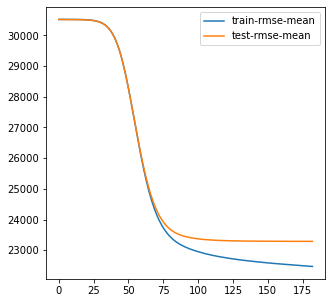

In [21]:
xgb_cv_results = xgb.cv(dtrain=xgb.DMatrix(X_xgb, label=y), params=params, nfold=5,num_boost_round=300,early_stopping_rounds=20,metrics='rmse',as_pandas=True)
plt.rcParams['figure.figsize'] = [5, 5]
_ = xgb_cv_results.filter(regex='mean').plot()

In [22]:
best_xgb = xgb.train(params=params, dtrain=xgb.DMatrix(X_xgb, label=y), num_boost_round=len(xgb_cv_results))

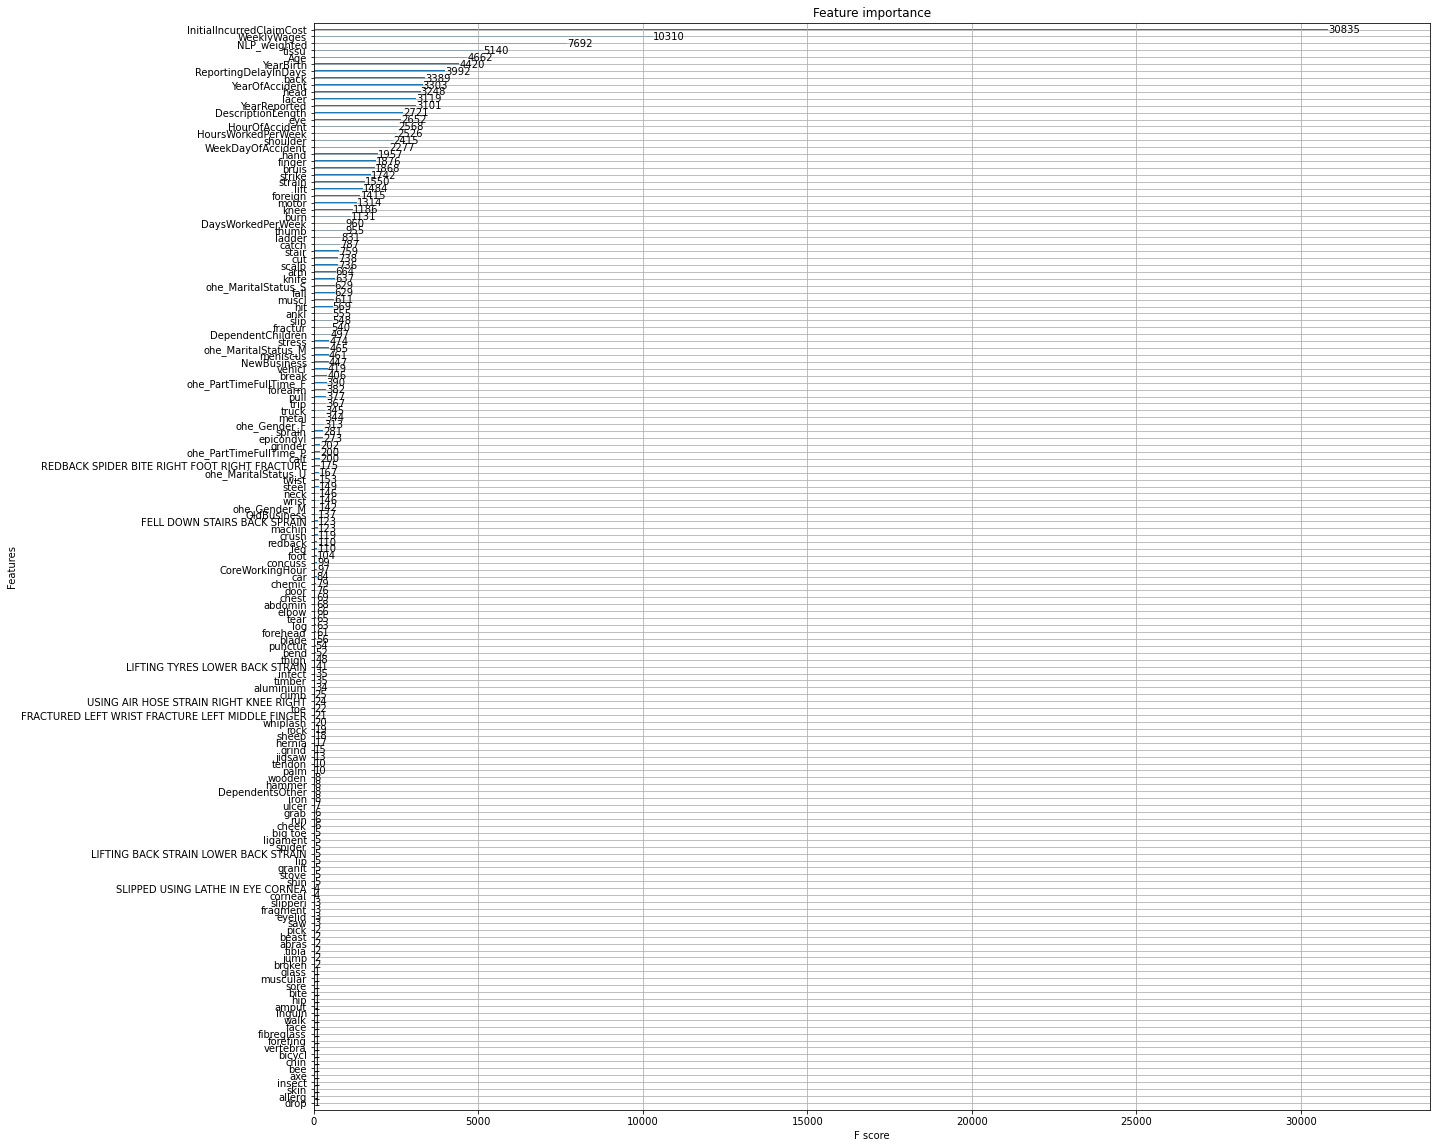

In [23]:
plt.rcParams['figure.figsize'] = [20, 20]
xgb.plot_importance(best_xgb)
plt.show()

# Error analysis

In [24]:
df_error = df.copy()
df_error['log_InitialIncurredClaimCost'] = np.log1p(df_error.InitialIncurredClaimCost)
df_error['log_UltimateIncurredClaimCost'] = np.log1p(df_error.UltimateIncurredClaimCost)

df_error['UltimateIncurredClaimCost_pred'] = best_xgb.predict(xgb.DMatrix(X_xgb))
df_error['log_UltimateIncurredClaimCost_pred'] = np.log1p(df_error.UltimateIncurredClaimCost_pred)

df_error['pred_error'] = df_error.UltimateIncurredClaimCost - df_error.UltimateIncurredClaimCost_pred
df_error['log_pred_error'] = np.log1p(df_error.pred_error)

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


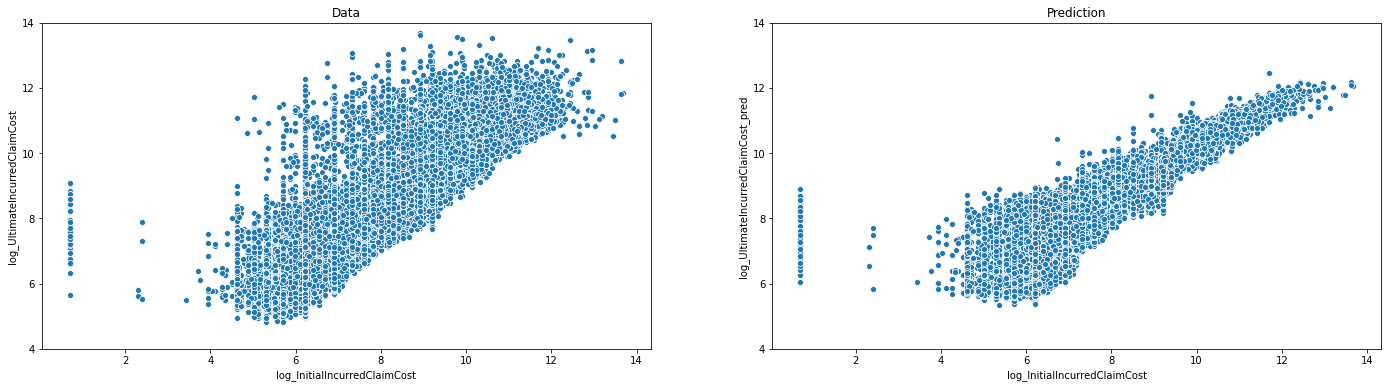

In [25]:
fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24,6))
sns.scatterplot(x='log_InitialIncurredClaimCost',y='log_UltimateIncurredClaimCost',data=df_error, ax=ax1)
ax1.set_title('Data')
ax1.set_ylim(bottom=4,top=14)
sns.scatterplot(x='log_InitialIncurredClaimCost',y='log_UltimateIncurredClaimCost_pred',data=df_error, ax=ax2)
ax2.set_title('Prediction')
ax2.set_ylim(bottom=4,top=14);

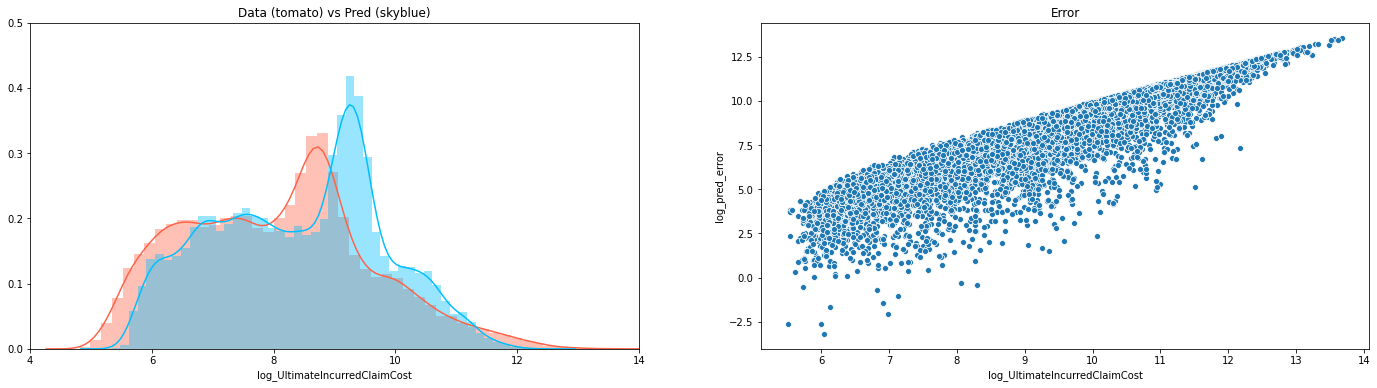

In [26]:
fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24,6))
sns.distplot(a=df_error['log_UltimateIncurredClaimCost'], ax=ax1, color='tomato')
ax1.set_title('Data (tomato) vs Pred (skyblue)'); ax1.set_xlim(left=4,right=14); ax1.set_ylim(bottom=0,top=0.5)
sns.distplot(a=df_error['log_UltimateIncurredClaimCost_pred'], ax=ax1, color='deepskyblue')
ax1.set_xlabel('log_UltimateIncurredClaimCost');

sns.scatterplot(x='log_UltimateIncurredClaimCost',y='log_pred_error',data=df_error, ax=ax2)
ax2.set_title('Error');

In [27]:
(df_error
 .loc[:,['log_InitialIncurredClaimCost','UltimateIncurredClaimCost','UltimateIncurredClaimCost_pred','ClaimDescription']]
 .assign(InitialIncurredClaimCost = np.exp(df_error.log_InitialIncurredClaimCost))
 .sort_values(by='UltimateIncurredClaimCost',ascending=False).head(10))

,log_InitialIncurredClaimCost,UltimateIncurredClaimCost,UltimateIncurredClaimCost_pred,ClaimDescription,InitialIncurredClaimCost
ClaimNumber,,,,,
WC4540054,8.922792,865770.6486,70803.898438,WHILST MASSAGING FELT PAIN SOFT TISSUE INJURY LEFT HAND,7501.0
WC2854573,8.922792,823706.3012,127897.148438,TABLE TIPPED OVER SOFT TISSUE INJURY RIGHT HAND,7501.0
WC8981820,9.791494,768485.1182,46108.402344,LIFTING BACK BACK STRAIN,17881.0
WC9097605,10.607995,742003.2335,77678.812500,SHEARING HAND PIECE BLISTER RIGHT HAND,40457.0
WC9789765,9.903538,741498.0275,49550.003906,LIFTING PARTS STRAIN BACK LOWER BACK STRAIN,20001.0
WC7286241,12.429220,713784.0636,193243.656250,LIFTING BOX FROM TOOL BOX HERNIA,250001.0
WC7977652,10.308986,608650.4259,42692.945312,LIFTING DRUM LOWER BACK PAIN,30001.0
WC9540190,9.159152,586912.8191,44574.359375,LIFTING KEGS LOWER BACK SOFT TISSUE INJURY LOWER BACK,9501.0
WC9879169,11.692635,558408.9616,256470.062500,CAUGHT BETWEEN DOOR FRAME GRAZE HEAD,119687.0


In [28]:
df_error.sort_values(by='log_pred_error',ascending=False).head(3)

,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredClaimCost,UltimateIncurredClaimCost,abdomin,ankl,arm,back,big toe,blood,bone,breast,calf,carpel tunnel,cheek,chest,chin,coccyx,collar bone,cornea,corneal,dental,ear,elbow,epicondyl,eye,eyelid,face,facial,finger,fingernail,foot,forearm,forefing,forehead,groin,hair,hand,head,heel,hip,inguin,jaw,knee,leg,ligament,lip,meniscus,mouth,muscl,muscular,nail,neck,nose,palm,patella,radius,scalp,scapula,shin,shoulder,skin,skull,sole,spine,sternum,stomach,tendon,thigh,thorac,throat,thumb,tibia,tissu,toe,tooth,torso,vein,vertebra,wrist,abras,allerg,allergi,amput,arthriti,break,broke,broken,bruis,burn,concuss,crush,cut,depress,disord,fractur,grind,headach,hernia,infect,inflamm,lacer,mental,multipl,nausea,punctur,sore,sprain,strain,stung,tear,torn,twist,ulcer,victimis,whiplash,abscess,aluminium,anxieti,axe,bang,bear,beast,bee,bend,bicycl,bite,blade,camel,car,catch,chainsaw,chemic,climb,cow,door,drop,explod,explos,fall,fibreglass,foreign,fragment,glass,grab,granit,grinder,hammer,hit,hors,insect,iron,jigsaw,jump,knife,ladder,lamb,lift,limeston,log,machin,metal,mirror,motor,motorcycl,mutton,overwork,pick,pig,pull,razor,redback,rock,run,saw,sharp,sheep,slip,slipperi,snake,spider,stair,steel,stove,stress,strike,timber,toxic,trip,truck,vehicl,walk,weld,wooden,YearOfAccident,WeekDayOfAccident,HourOfAccident,YearReported,YearBirth,ReportingDelay,ReportingDelayInDays,DescriptionLength,NewBusiness,OldBusiness,CoreWorkingHour,ohe_Gender_F,ohe_Gender_M,ohe_PartTimeFullTime_F,ohe_PartTimeFullTime_P,ohe_MaritalStatus_M,ohe_MaritalStatus_S,ohe_MaritalStatus_U,SLIPPED USING LATHE IN EYE CORNEA,REDBACK SPIDER BITE RIGHT FOOT RIGHT FRACTURE,LIFTING TYRES LOWER BACK STRAIN,LIFTING BACK STRAIN LOWER BACK STRAIN,FELL DOWN STAIRS BACK SPRAIN,USING AIR HOSE STRAIN RIGHT KNEE RIGHT,FRACTURED LEFT WRIST FRACTURE LEFT MIDDLE FINGER,NLP_weighted,log_InitialIncurredClaimCost,log_UltimateIncurredClaimCost,UltimateIncurredClaimCost_pred,log_UltimateIncurredClaimCost_pred,pred_error,log_pred_error
ClaimNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
WC4540054,1994-09-22 20:00:00+00:00,1994-11-29 00:00:00+00:00,37,M,M,0,0,200.00,F,39.0,5,WHILST MASSAGING FELT PAIN SOFT TISSUE INJURY LEFT HAND,7500,865770.6486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1994,3,20,1994,1957,67 days 04:00:00,67,9,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,10.0,8.922792,13.671376,70803.898438,11.167684,794966.750162,13.586057
WC8981820,2003-02-27 10:00:00+00:00,2003-03-29 00:00:00+00:00,40,M,S,0,0,523.47,F,38.0,5,LIFTING BACK BACK STRAIN,17880,768485.1182,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

# Submission

In [29]:
data_test=load_data(path='../input/actuarial-loss-estimation/test.csv')
df_test=add_NLP(data_test, cluster = False, verbose = True)
dg_test=add_NLP(data_test, verbose = True, cluster = True).loc[:,"C_one":"C_twentynine"]
u = list(dg_test.columns)
for column in dg_test.columns:
    dg_test[column] *= (u.index(column) + 1)^2
weights_test = dg_test.loc[:,'C_one':'C_twentynine'].sum(axis=1)
df_test_xgb = preprocess(df_test)

df_test_xgb["NLP_weighted"] = weights_test

bp :  (35044, 76)
wt :  (27182, 36)
ac :  (27553, 78)
Rows classified:  (35939, 190)
bp :  (35044, 76)
wt :  (27182, 36)
ac :  (27553, 78)
Rows classified:  (35939, 44)


In [30]:
X_test_xgb = df_test_xgb.filter(items=X_xgb.columns)
dmatrix = xgb.DMatrix(data=X_test_xgb)
pred = best_xgb.predict(data=dmatrix)

In [31]:
def create_download_link(filename, title):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

In [32]:
#submission setup
cet = tz.gettz('Europe/Rome')
now = datetime.now(cet).strftime("%Y%m%dT%H%M%S")
foldername = './submission_{}'.format(now)
os.mkdir(foldername)

# create submission file
df_submission = pd.DataFrame(data={'ClaimNumber':df_test_xgb.index,'UltimateIncurredClaimCost':pred})
filename_submission = os.path.join(foldername,'submission_{}.csv'.format(now))
df_submission.to_csv(path_or_buf=filename_submission,index=False)

#save processed test dataset
filename_data = os.path.join(foldername,'data_{}.csv'.format(now))
df_test_xgb.to_csv(path_or_buf=filename_data,index=False)

#save model info
filename_info = os.path.join(foldername,'info_{}.json'.format(now))
with open(filename_info, 'w') as f: json.dump(analysis.best_result, f)

#zip all info for download
from zipfile import ZipFile
filename_archive = 'submission_{}.zip'.format(now)
filenames = os.listdir(foldername)
with ZipFile(filename_archive, 'w') as f:
    for filename in filenames:
        f.write(os.path.join(foldername, filename))

#check submission
! head -3 $filename_submission

ClaimNumber,UltimateIncurredClaimCost
WC8145235,7611.548
WC2005111,4823.387


In [33]:
create_download_link(filename=filename_submission, title = "Click here to download the latest submission file")

In [34]:
create_download_link(filename=filename_archive, title = "Click here to download the all submission info")